# Original Pe

### Original transformer positional encoding method.<br>  

## Libraries

In [1]:

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle
import Transformer
import data_loader

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator-1\Experiment_2\transformer


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Data preparation

In [4]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))

# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

## Split train, validation and testing set from X_train and Y_train with percentages of 60%, 20%, 20%.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_train, 
                                                    Y_train, 
                                                    test_size=0.2, 
                                                    shuffle = True, 
                                                    random_state = 8)

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state= 8)

In [6]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


## Plot a few training samples

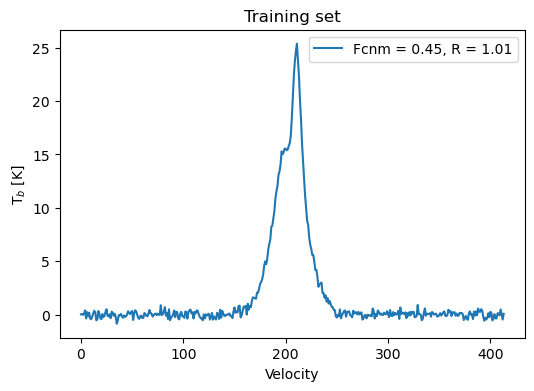

In [8]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')
plt.legend()
plt.show()

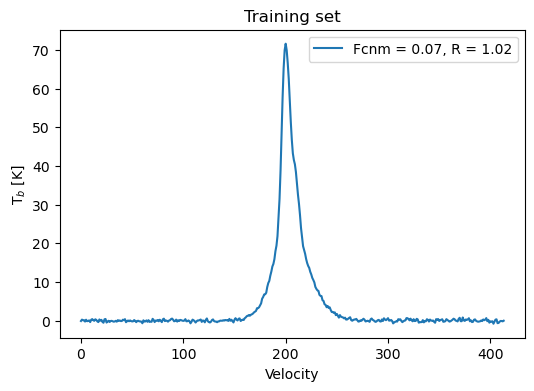

In [9]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(Y_train[10000,0], 2)}, R = {round(Y_train[10000,1], 2)}')
plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')
plt.legend()
plt.show()

## Data loader

In [7]:

dataset_train = data_loader.spectra_loader(x_train, 
                                           y_train,
                                           transform=data_loader.ToTensor(),
                                           target_transform=data_loader.ToTensor(), 
                                           pe='sin_add')

dataset_val = data_loader.spectra_loader(x_val,
                                         y_val,
                                         transform=data_loader.ToTensor(), 
                                         target_transform=data_loader.ToTensor(),
                                         pe='sin_add')

dataset_test = data_loader.spectra_loader(x_test, 
                                          y_test,
                                          transform=data_loader.ToTensor(),
                                          target_transform=data_loader.ToTensor(),
                                          pe='sin_add')

In [8]:
# initialize data loader
batch_size = 20 
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, 
                                           batch_size = batch_size,
                                           shuffle =True)

valid_loader = torch.utils.data.DataLoader(dataset = dataset_val,
                                           batch_size = batch_size, 
                                           shuffle =False)

test_loader = torch.utils.data.DataLoader(dataset = dataset_test,
                                          batch_size = batch_size, 
                                          shuffle =False)

In [9]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 1, 414])
torch.Size([20, 2])


## Model Training and Evaluation 

In [1]:
# train 
def train(epoch):
    """
    Train the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.

    Returns
    -------
    train_loss/total: The mean MSE in an epoch.     
    """
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print("total loss=",train_loss)
    return train_loss/total

In [2]:
def validation(epoch):
    """
    validate the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.

    Returns
    -------
    error: The mean MSE in validation set. 
        
    """
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    print(f"validation MSE in epoch {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/s8_original_pe.pth')
        best_err = error
    return error

In [3]:
def test(epoch):
    """
    test the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.
    Returns
    -------
    error: The mean MSE in test set. 
    """
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        #print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')
        return test_loss/total

## Training: 10 trail 

In [18]:
# define number of trails, number of epoch and learning rate
num_trial = 10
num_epoch = 80
learning_rate = 0.005
# the savier of best validation performance and coresponding testing performance.
vali = []
testing = []
# saver for each trials
train_trails = []
validate_trails =[]
test_trails = []

In [19]:
def trail(num_epoch):
    global vali
    global testing
    global scheduler
    global model
    global lr
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch)
        scheduler.step()
        test_err = test(epoch)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model()
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [4]:
def validate_model():
    global model
    model = Transformer.Transformer(num_output=2,
                                    in_channels=1,
                                    input_row=1, 
                                    input_column=414,
                                    ipe=True)
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    checkpoint = torch.load('./checkpoint/s8_original_pe.pth',map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch)
    test_error = test(epoch)
    return validation_error, test_error

In [21]:
# start 10 trails.
for i in range (0, num_trial):
    print(f'start the {i}th trial:')
    # model initialization
    lr=learning_rate
    model = Transformer.Transformer(num_output=2,
                                    in_channels=1, 
                                    input_row=1, 
                                    input_column=414,
                                    ipe=True)
    
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    optimizer = torch.optim.SGD(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                     milestones = [65], 
                                                     gamma=0.1, last_epoch=-1, 
                                                     verbose=False)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    trail(num_epoch)

start the 0th trial:
total loss= 617.3157700123265
validation MSE in epoch 0=  0.01806820806739309
best_err: 0.01806820806739309 Saving..
total loss= 357.1990126548335
validation MSE in epoch 1=  0.027628559585086244
total loss= 296.9526833631098
validation MSE in epoch 2=  0.010439482843791542
best_err: 0.010439482843791542 Saving..
total loss= 287.3089946578257
validation MSE in epoch 3=  0.009774971446860533
best_err: 0.009774971446860533 Saving..
total loss= 265.91930141765624
validation MSE in epoch 4=  0.025910707168058215
total loss= 266.9602818018757
validation MSE in epoch 5=  0.009796500207614701
total loss= 250.17831836501136
validation MSE in epoch 6=  0.008428949693769271
best_err: 0.008428949693769271 Saving..
total loss= 243.0876362659037
validation MSE in epoch 7=  0.011661752513641047
total loss= 241.0167309665121
validation MSE in epoch 8=  0.011957863637771172
total loss= 242.03125824872404
validation MSE in epoch 9=  0.011555478316859033
total loss= 237.036525472532

# Results

## 1. plot the training and validation and testing chart

In [5]:
def plott(x, ti):
    """
    A method to plot training process.
    ...
    Parameters
    ----------
    x : nparray.
        the data to plot with shape of (800,1).
    ti : str
        The title of the plot.
    """
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

In [6]:
def plott_20(x, ti):
    """
    A method to plot training process in the last 20 epoch.
    ...
    Parameters
    ----------
    x : nparray.
        the data to plot with shape of (800, ).
    ti : str
        The title of the plot.
    """
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index+59: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails(last 20 epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

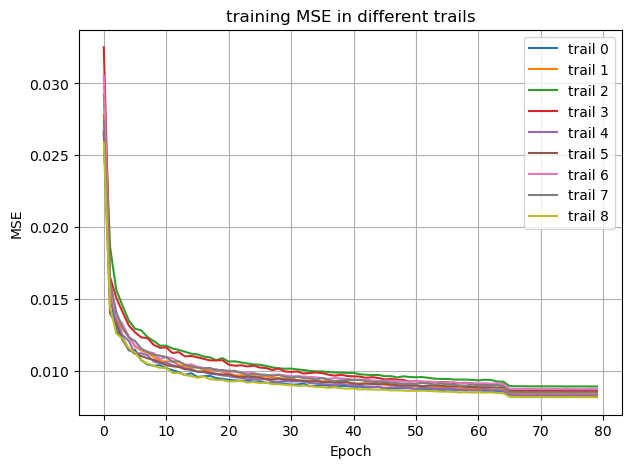

In [24]:
# training 
x = np.array(train_trails)
plott(x, "training")

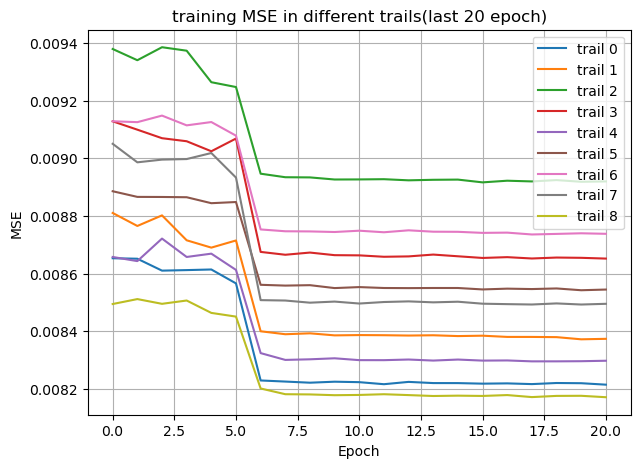

In [25]:
# training 
x = np.array(train_trails)
plott_20(x, "training")

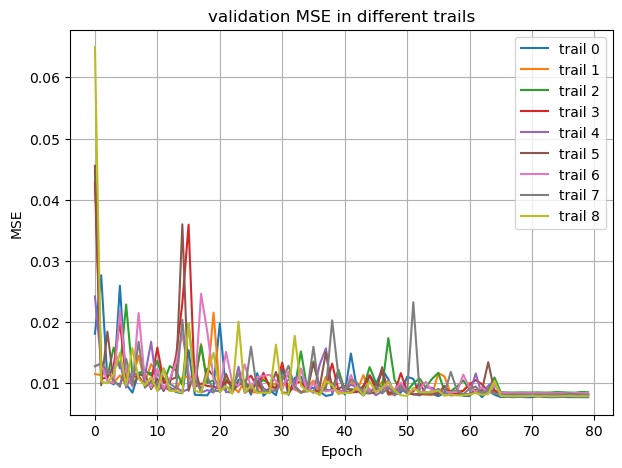

In [26]:
# validation
x = np.array(validate_trails)
plott(x, "validation")

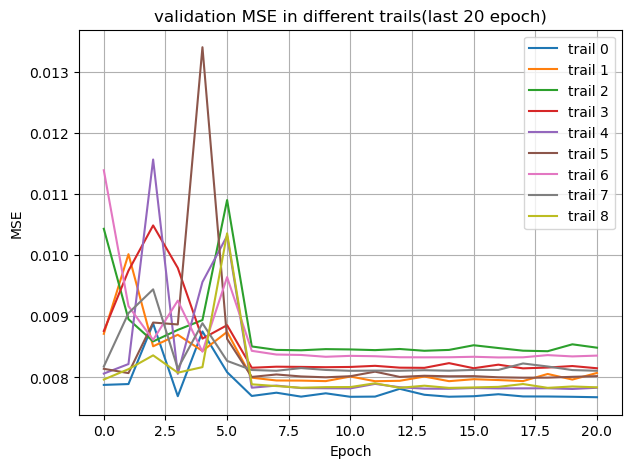

In [27]:
# validation
x = np.array(validate_trails)
plott_20(x, "validation")

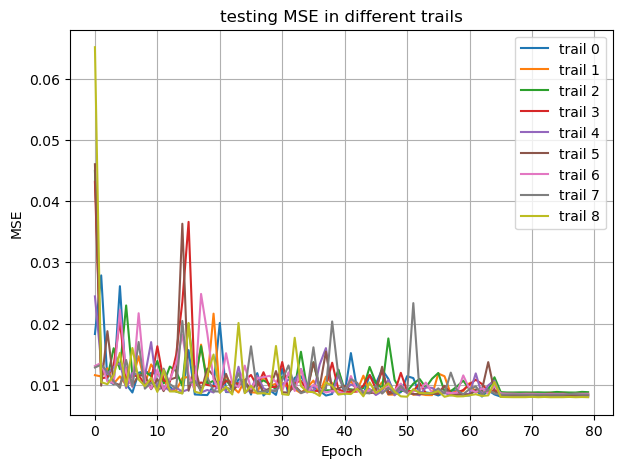

In [28]:
# testing 
x = np.array(test_trails)
plott(x, "testing")

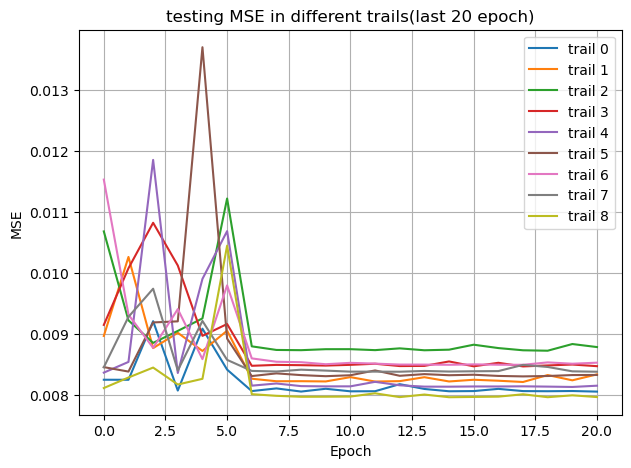

In [29]:
# testng
x =  np.array(test_trails)
plott_20(x, "testing")

## 2. plot the best velidation MSE and testing MSE

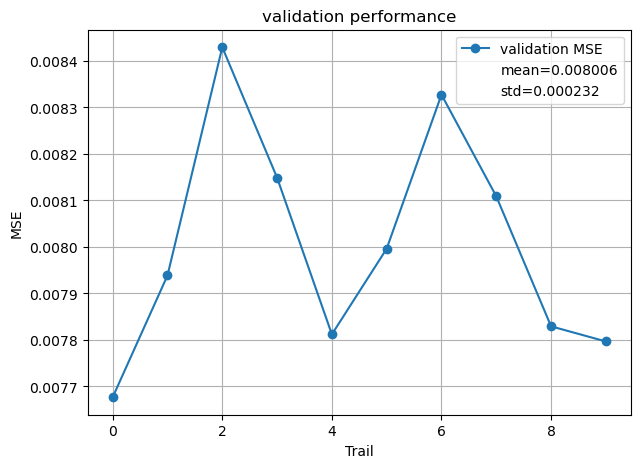

validation mean= 0.008006441283940091
validation std= 0.00023224835227817525


In [30]:
x = vali
plt.figure(figsize=(7,5))
plt.title('validation performance')
plt.plot(x, label='validation MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),6)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),6)}")
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("validation mean=",np.mean(x))
print("validation std=",np.std(x))

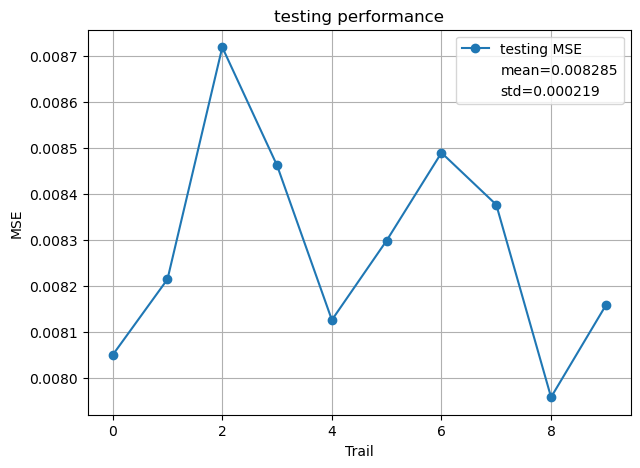

testing mean= 0.008284863624090238
testing std= 0.0002191891128417698


In [31]:
x = testing
plt.figure(figsize=(7,5))
plt.title('testing performance')
plt.plot(x, label='testing MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),6)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),6)}")
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("testing mean=",np.mean(x))
print("testing std=",np.std(x))

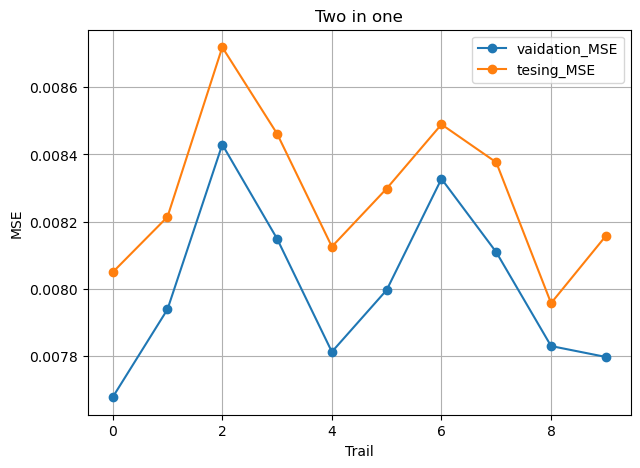

In [32]:
x1 = vali
x2 = testing
plt.figure(figsize=(7,5))
plt.title('Two in one')
plt.plot(x1, label='vaidation_MSE',marker='o')
plt.plot(x2, label='tesing_MSE',marker='o')
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

## Save csv

In [33]:
x1 = np.array(vali).reshape(1, -1)
x2 = np.array(testing).reshape(1, -1)
two = np.vstack((x1,x2))
df = pd.DataFrame(two).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\s8_original_pe.csv")

In [34]:
# save data 
x1 = np.array(train_trails).reshape(1, -1)
x2 = np.array(validate_trails).reshape(1, -1)
x3 = np.array(test_trails).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\s8_original_pe_process.csv")